In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cmocean
import numpy as np

In [2]:
agcd_file = '/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6/AGCD/ACCESS-CM2/ssp370/r4i1p1f1/day/pr/2070-2099/pr_day_ACCESS-CM2_ssp370_r4i1p1f1_AUS-05_2093_qdc-multiplicative-q1000-linear_AGCD-baseline-1985-2014_model-baseline-1985-2014.nc'

In [3]:
agcd_ds = xr.open_dataset(agcd_file)

In [4]:
agcd_ds

<xarray.Dataset>
Dimensions:  (time: 365, lon: 886, lat: 691)
Coordinates:
  * time     (time) datetime64[ns] 2093-01-01 2093-01-02 ... 2093-12-31
  * lon      (lon) float32 112.0 112.1 112.1 112.2 ... 156.1 156.1 156.2 156.2
  * lat      (lat) float32 -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
Data variables:
    pr       (time, lat, lon) float32 ...
Attributes: (12/43)
    CDI:                       Climate Data Interface version 2.0.5 (https://...
    source:                    Data from Australian Gridded Climate Data v1.0...
    institution:               Commonwealth Scientific and Industrial Researc...
    Conventions:               CF-1.8, ACDD-1.3
    xclim:                     [2024-06-08 03:44:57] precip: jitter(x=precip,...
    geospatial_lat_min:        -44.525
    ...                        ...
    summary:                   The data have been created by applying climate...
    time_coverage_resolution:  PT1440M0S
    title:                     QDC-Scaled CMIP6 Application-Ready Climate Pro...
    creation_date:             2024-06-08T03:45:11.260178
    history:                   Tue Jun 11 16:37:51 2024: cdo -z zip_5 -seldat...
    CDO:                       Climate Data Operators version 2.0.5 (https://...

In [5]:
barra_file = '/g/data/ia39/australian-climate-service/test-data/QDC-CMIP6/BARRA-R2/ACCESS-CM2/ssp370/r4i1p1f1/day/pr/2070-2099/pr_day_ACCESS-CM2_ssp370_r4i1p1f1_AUS-11_2093_qdc-multiplicative-q1000-linear_BARRA-R2-baseline-1985-2014_model-baseline-1985-2014.nc'

In [6]:
barra_ds = xr.open_dataset(barra_file)

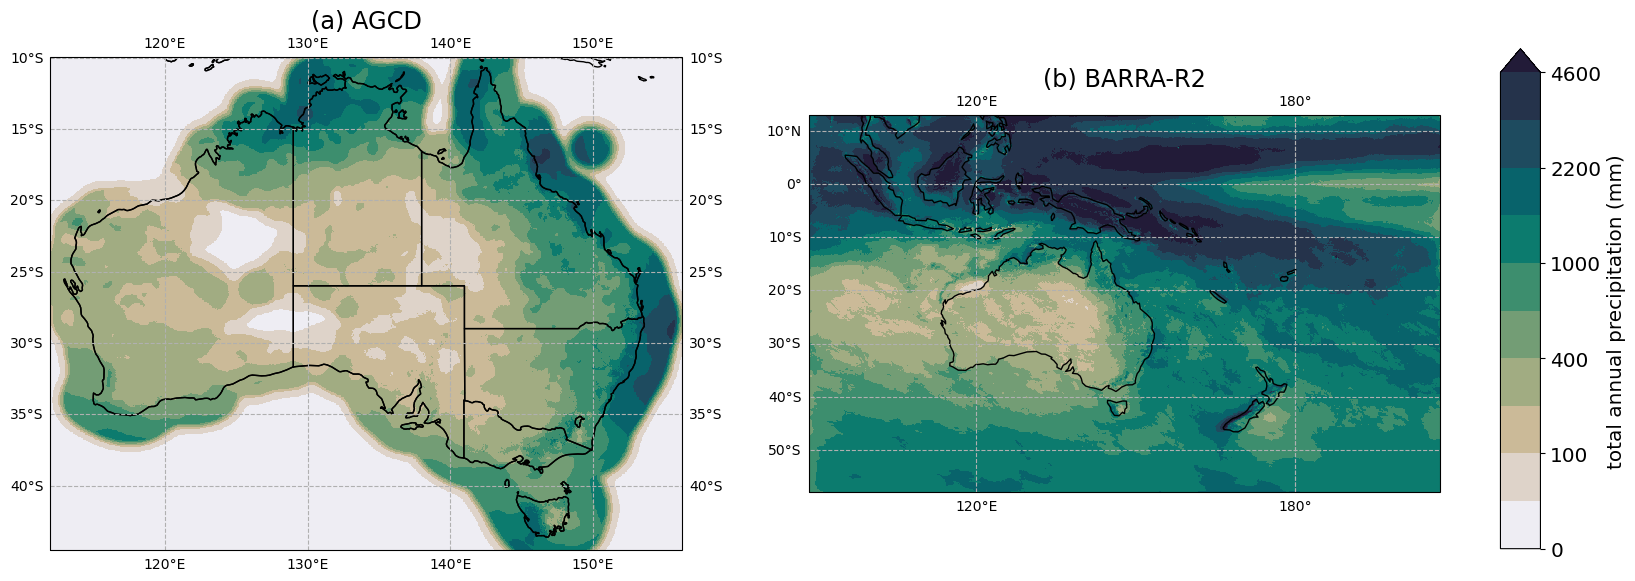

In [26]:
fig = plt.figure(figsize=[20, 10])
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree(central_longitude=180))
ax2 = fig.add_subplot(122, projection=ccrs.PlateCarree(central_longitude=180))

cmap = cmocean.cm.rain
levels = [0, 10, 100, 200, 400, 600, 1000, 1400, 2200, 3000, 4600]

agcd_ds['pr'].sum('time').plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels,
    extend='max',
#    cbar_kwargs={'label': 'annual precipitation (mm)'},
    add_colorbar=False,
)
ax1.coastlines()
ax1.add_feature(cartopy.feature.STATES)
ax1.gridlines(linestyle='--', draw_labels=True)
ax1.set_title('(a) AGCD', size='xx-large')

im = barra_ds['pr'].sum('time').plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    levels=levels,
    extend='max',
    add_colorbar=False,
)
ax2.coastlines()
ax2.add_feature(cartopy.feature.STATES)
ax2.gridlines(linestyle='--', draw_labels=True)
ax2.set_title('(b) BARRA-R2', size='xx-large')

fig.subplots_adjust(right=0.82)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize='x-large')
cbar.set_label('total annual precipitation (mm)', size='x-large')

plt.savefig(
    f'pr_annual_ACCESS-CM2_ssp370_r4i1p1f1_native_2093_qdc-multiplicative-q1000-linear_AGCD-BARRA-R2-baseline-1985-2014_model-baseline-1985-2014.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300
)
plt.show()